# CIFAKE-based model
In this notebook, we will experiment with training various model on the CIFAKE dataset.

The CIFAKE contains around 120k images, which can either be real or AI generated. The images have a 32x32 resolution, so it will be interesting to see if our models can capture the patterns correctly even if the resolution is so low.

In [36]:
import torch
from torchvision.models import resnet18, resnet50
import model_utils
import plotter
import data_utils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
import importlib
import torchvision.transforms as transforms

import xai

model_utils.fix_random(42)

# if true train models, do not load checkpoints
TRAINING_MODE=True

# show plots
plotter.set_display_mode(True)

True

In [37]:
# import model to finetune
ft_resnet18 = resnet18(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet18, num_classes=2)
device = model_utils.get_device()
print(f"using {device} device")
ft_resnet18.to(device)

transform_cifake = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')), # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])        # normalize pixel values
])

LEARNING_RATE = 3e-4
EPOCHS = 10
BATCH_SIZE = 128
DATASET_NAME = "CIFAKE"

using cuda device


In [38]:
train_data = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="train", transform=transform_cifake)
test_data = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="test", transform=transform_cifake)

val_data, test_data = data_utils.train_test_split(0.5, dataset=test_data, isRandom=True)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, pin_memory=True)
dataloaders = (train_dataloader, test_dataloader)

## Baseline CNN training
To get a baseline for the performance of how dataset performs, we've decided to train a model from the ground up, which serves as a baseline. The model consists on a CNN with the following specifications:
- 3 Convolutional Layers:
    - Conv1: input channels = 3, output channels = 32, kernel size = 3x3.
    - Conv2: input channels = 32, output channels = 64, kernel size = 3x3.
    - Conv3: input channels = 64, output channels = 128, kernel size = 3x3.
- 3 Fully Connected layers:
    - fc1: maps the flattened tensor to 512 features.
    - fc2: maps 512 features to 256.
    - fc3: outputs predictions for the number of classes (num_classes).

Using 3 layers with a 3x3 kernel is usually a popular choice for this kind of models, as represents a good balance between model complexity and training feasibility.

In [39]:
baseline_model = model_utils.CNN(input_width=32, input_height=32)
baseline_model.to(device)
model_name = "CIFAKE_BaseCNN"
optimizer = torch.optim.AdamW(baseline_model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.BCEWithLogitsLoss()

In [40]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer,
                              baseline_model, model_name, BATCH_SIZE,
                              EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/10
-------------------------------
Training loss: 0.392069, train accuracy: 76.74%  [ 5120/100000]
Training loss: 0.393691, train accuracy: 80.74%  [10240/100000]
Training loss: 0.245972, train accuracy: 82.86%  [15360/100000]
Training loss: 0.307902, train accuracy: 84.41%  [20480/100000]
Training loss: 0.349444, train accuracy: 85.52%  [25600/100000]
Training loss: 0.288949, train accuracy: 86.26%  [30720/100000]
Training loss: 0.363328, train accuracy: 86.96%  [35840/100000]
Training loss: 0.229475, train accuracy: 87.41%  [40960/100000]
Training loss: 0.194694, train accuracy: 87.82%  [46080/100000]
Training loss: 0.278878, train accuracy: 88.19%  [51200/100000]
Training loss: 0.198955, train accuracy: 88.50%  [56320/100000]
Training loss: 0.136295, train accuracy: 88.81%  [61440/100000]
Training loss: 0.233026, train accuracy: 89.11%  [66560/100000]
Training loss: 0.171801, train accuracy: 89.36%  [71680/100000]
Training loss: 0.154144, train accuracy: 89.58%  [76800/10000

Test Error:
Accuracy: 95.5%, Avg loss: 0.115136
Confusion matrix report, tp: 4693, fp: 292, fn: 162, tn:4853
True


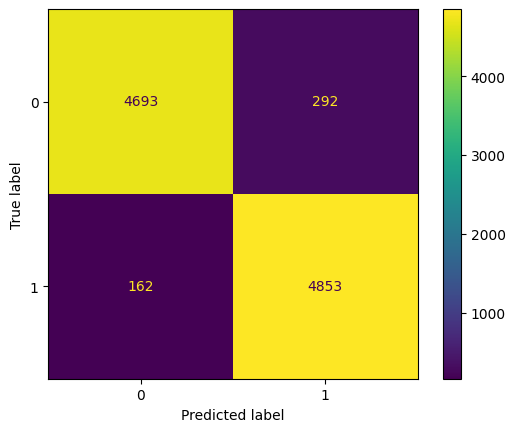

Precision: 0.94, Recall: 0.97, F1-Score: 0.95


(0.11513566489838346, tensor(0.9546, device='cuda:0'))

In [41]:
model_utils.test(test_dataloader, baseline_model, loss_fn, device,
                 model_name=model_name)

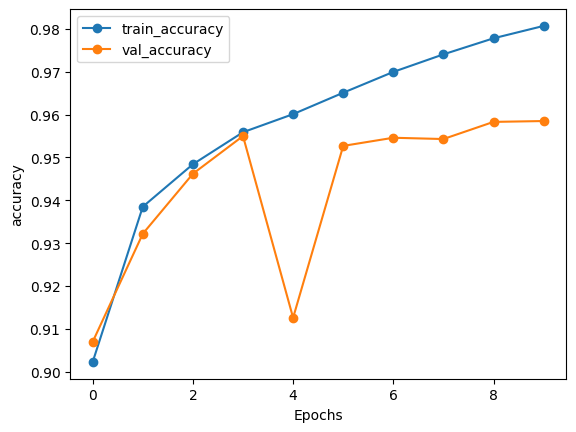

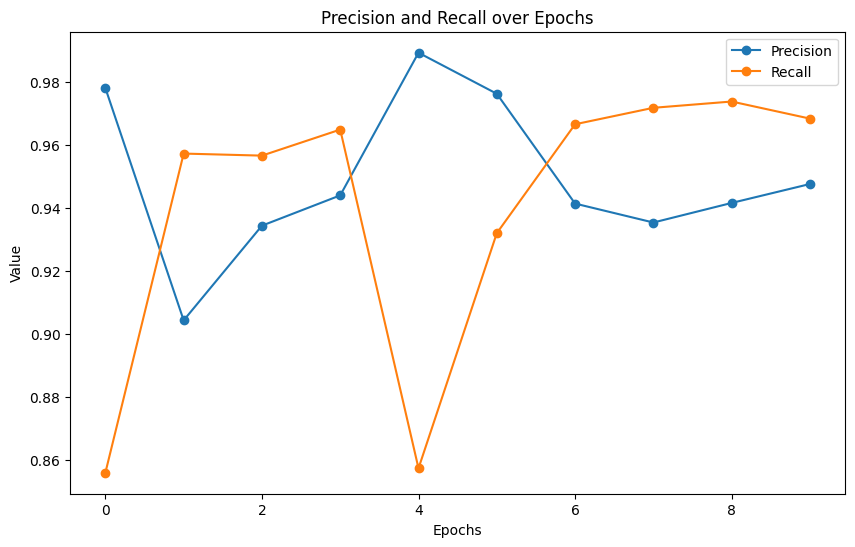

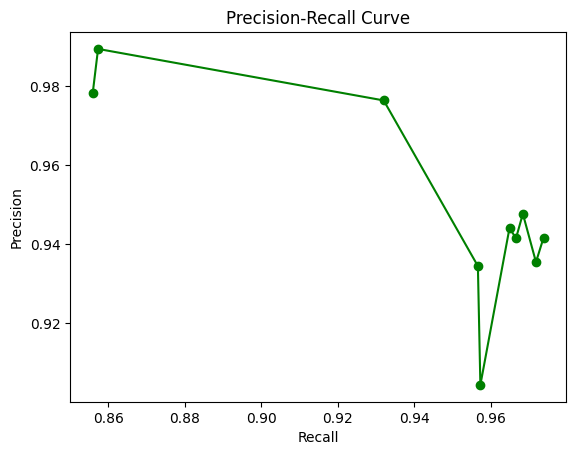

In [42]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

## Finetuning a ResNet50

ResNet-50 is a popular deep learning architecture primarily designed to solve the problem of vanishing gradients in deep neural networks. It utilizes residual connections, which allow the model to bypass one or more layers. This design makes it easier for the network to learn identity mappings.

Because it's one of the most effective architecture used in image classification, we adopt it to tackle this task.

Previously, we experimented with fine-tuning a ResNet-18 architecture. However, we achieved better results with the current technique.

The fine-tuning process we used consists in 2 steps:
1. we train the classification head first, freezing the feature extractor.
2. we unfreeze the feature extractor, and train it with the new fine-tuned classification head.

Since the dataset is very vast, we could only afford to train for 10 epochs. However, using this configuration still gave us good results.

In [8]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=2)
ft_resnet50.to(device)

optimizer = torch.optim.AdamW(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)
model_name = "CIFAKE_FTResNet50"

In [9]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer,
                              ft_resnet50, model_name, BATCH_SIZE,
                              EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/10
-------------------------------
Training loss: 0.583783, train accuracy: 65.70%  [ 5120/100000]
Training loss: 0.559490, train accuracy: 69.61%  [10240/100000]
Training loss: 0.563239, train accuracy: 71.48%  [15360/100000]
Training loss: 0.498168, train accuracy: 72.70%  [20480/100000]
Training loss: 0.510178, train accuracy: 73.54%  [25600/100000]
Training loss: 0.524391, train accuracy: 74.20%  [30720/100000]
Training loss: 0.465169, train accuracy: 74.61%  [35840/100000]
Training loss: 0.453355, train accuracy: 75.01%  [40960/100000]
Training loss: 0.490054, train accuracy: 75.35%  [46080/100000]
Training loss: 0.501651, train accuracy: 75.63%  [51200/100000]
Training loss: 0.473350, train accuracy: 75.81%  [56320/100000]
Training loss: 0.417830, train accuracy: 76.04%  [61440/100000]
Training loss: 0.544007, train accuracy: 76.16%  [66560/100000]
Training loss: 0.428425, train accuracy: 76.35%  [71680/100000]
Training loss: 0.408535, train accuracy: 76.51%  [76800/10000

Test Error:
Accuracy: 82.7%, Avg loss: 0.387721
Confusion matrix report, tp: 4117, fp: 868, fn: 864, tn:4151
True


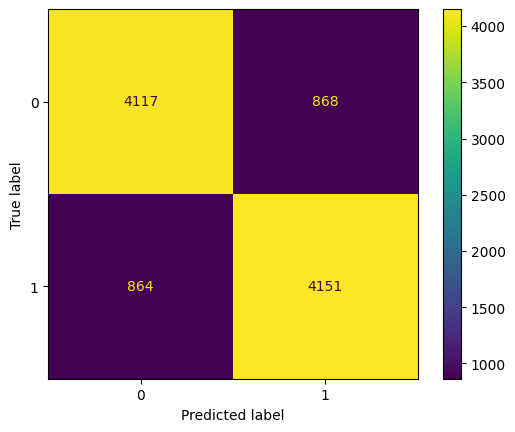

Precision: 0.83, Recall: 0.83, F1-Score: 0.83


(0.3877210954699335, tensor(0.8268, device='cuda:0'))

In [10]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)

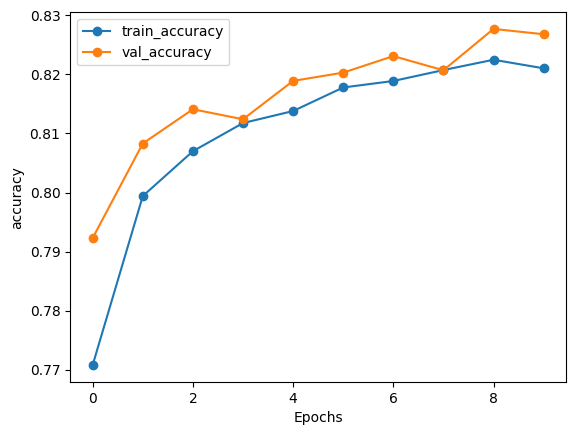

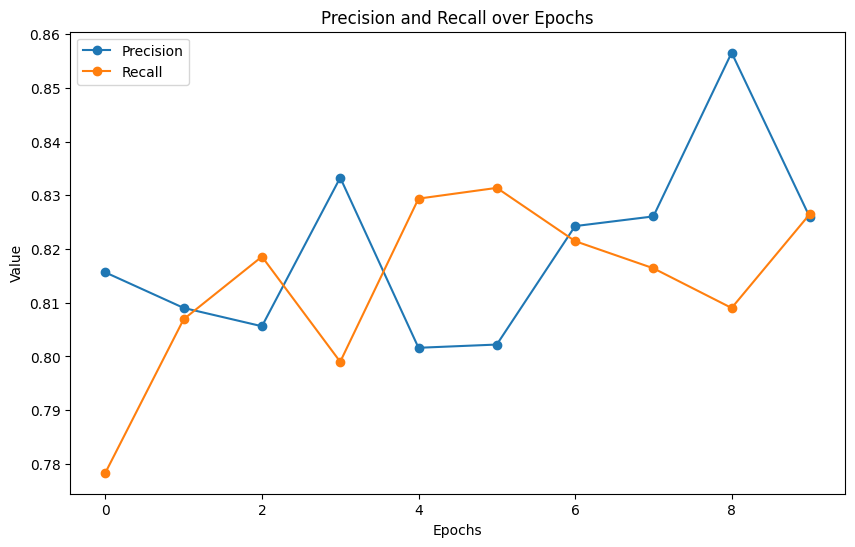

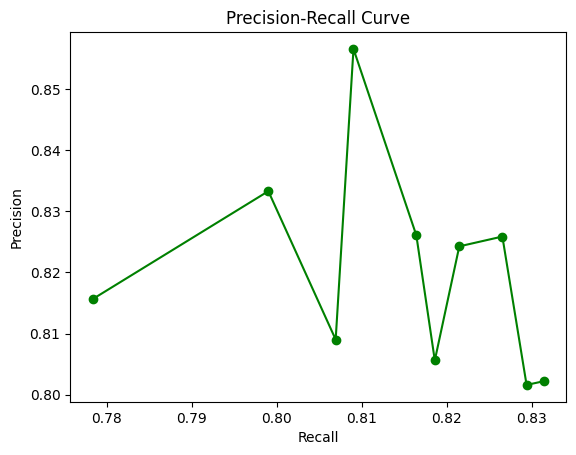

In [11]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

#### Fine-tuning, step 2
As previously mentioned, in this step we are going to train the feature extractor using the classification head has been already fine-tuned.

By training the classification head first, the network learns task-specific decision boundaries using the frozen features from the pre-trained extractor.

Next, fine-tuning the feature extractor allows it to learn features that are relevant and specific to the task.

In [12]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)
model_name = "CIFAKE_FTResNet50_beefy"

In [13]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/10
-------------------------------
Training loss: 0.162458, train accuracy: 85.78%  [ 5120/100000]
Training loss: 0.229985, train accuracy: 88.63%  [10240/100000]
Training loss: 0.116672, train accuracy: 90.44%  [15360/100000]
Training loss: 0.092908, train accuracy: 91.42%  [20480/100000]
Training loss: 0.098029, train accuracy: 92.04%  [25600/100000]
Training loss: 0.102035, train accuracy: 92.58%  [30720/100000]
Training loss: 0.147183, train accuracy: 92.95%  [35840/100000]
Training loss: 0.096738, train accuracy: 93.30%  [40960/100000]
Training loss: 0.153712, train accuracy: 93.52%  [46080/100000]
Training loss: 0.070461, train accuracy: 93.73%  [51200/100000]
Training loss: 0.100039, train accuracy: 93.91%  [56320/100000]
Training loss: 0.032469, train accuracy: 94.09%  [61440/100000]
Training loss: 0.157257, train accuracy: 94.23%  [66560/100000]
Training loss: 0.057611, train accuracy: 94.37%  [71680/100000]
Training loss: 0.053143, train accuracy: 94.49%  [76800/10000

Test Error:
Accuracy: 98.0%, Avg loss: 0.083348
Confusion matrix report, tp: 4857, fp: 128, fn: 167, tn:4848
True


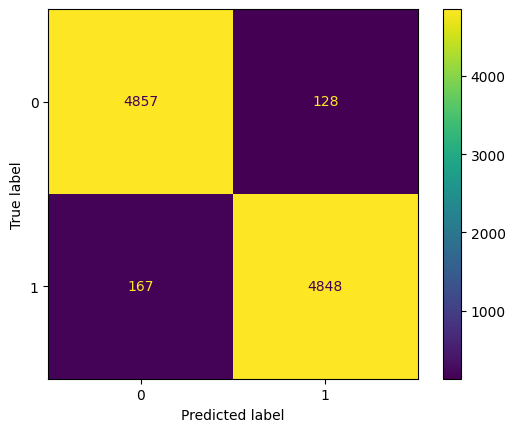

Precision: 0.97, Recall: 0.97, F1-Score: 0.97


(0.08334811841715363, tensor(0.9705, device='cuda:0'))

In [14]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)

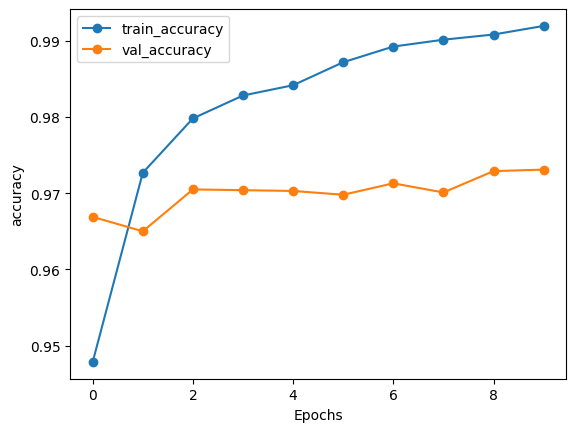

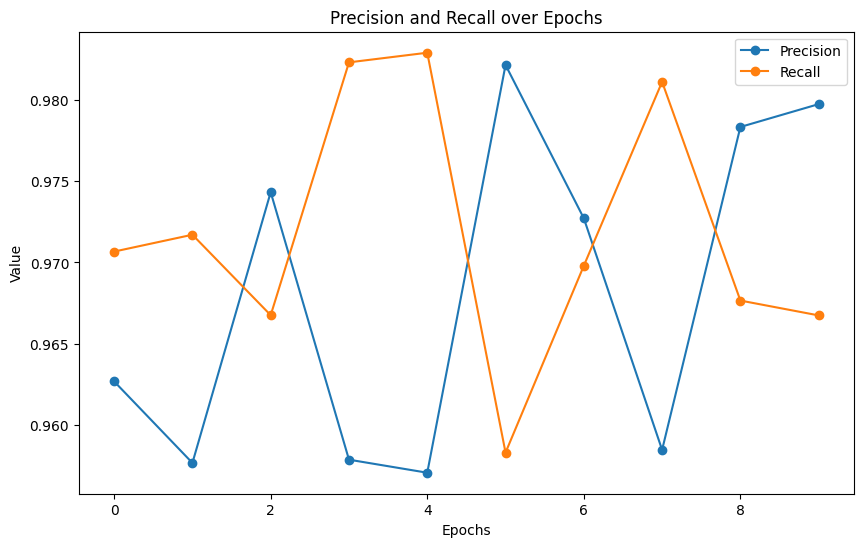

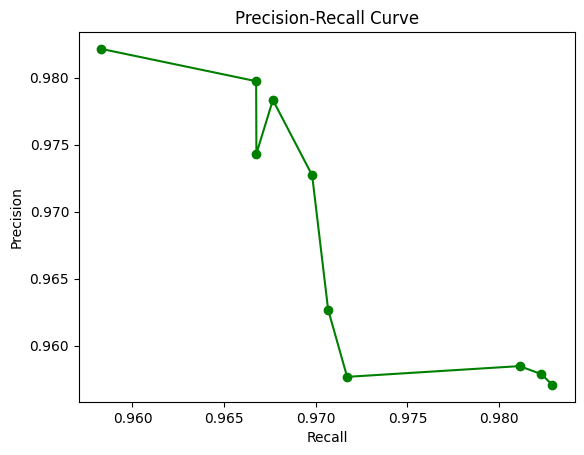

In [15]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

With this method, we are able to achieve really good performance on the test set accuracy.

The reason for such a high accuracy could be due to various aspects, however we believe that most influencing factor to be the quality of the dataset.
CIFAKE has 120000 samples, all of which have been transformed (i.e. some of the samples are patches of higher resolution images) and modified to allow for a network to learn easily what makes an image fake (e.g. the noise patter).

In addition, ResNet-50 being an high capacity model certainly influenced the final results, as we were not able to achieve such result while experimenting with ResNet-18.

## Secondary experiments
The following sections present other interesting experiments conducted during the development process. We explored various architectures and techniques, but none managed to surpass the performance achieved with ResNet-50.

In fact, the final accuracy scores showed no significant improvement over those obtained with ResNet-50 at best and were consistently lower at worst.


#### Modified ResNET (3 LL)
The model consists on a standard ResNet-50 with an enhanced classification head (3 LL instead of 1).
The reasoning behind this model was that the belief that the introduction of additional layers could help in making more complex decisions on the pre-trained f.e., and could achieved better scores during the 1st step of fine-tuning (and thus, reduce training time by using a single step fine tuning procedure).

The final results showed that this was not the case however, as even fine-tuning the model using 2 steps could not the reach the results of the previous model.

In [16]:
mod_resnet50 = model_utils.ModifiedResNet(original_resnet=resnet50(weights='IMAGENET1K_V1'))

In [17]:
mod_resnet50.prepare_for_ft()
mod_resnet50.to(device)

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, mod_resnet50.parameters()), lr=0.001
)

model_name = "CIFAKE_ModResNet50"

In [18]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, mod_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/10
-------------------------------
Training loss: 0.549478, train accuracy: 70.98%  [ 5120/100000]
Training loss: 0.446189, train accuracy: 73.54%  [10240/100000]
Training loss: 0.408013, train accuracy: 75.12%  [15360/100000]
Training loss: 0.465289, train accuracy: 75.61%  [20480/100000]
Training loss: 0.392288, train accuracy: 75.99%  [25600/100000]
Training loss: 0.442237, train accuracy: 76.48%  [30720/100000]
Training loss: 0.396108, train accuracy: 76.88%  [35840/100000]
Training loss: 0.465265, train accuracy: 77.15%  [40960/100000]
Training loss: 0.462243, train accuracy: 77.36%  [46080/100000]
Training loss: 0.491473, train accuracy: 77.69%  [51200/100000]
Training loss: 0.379770, train accuracy: 77.87%  [56320/100000]
Training loss: 0.451423, train accuracy: 78.15%  [61440/100000]
Training loss: 0.449370, train accuracy: 78.39%  [66560/100000]
Training loss: 0.384170, train accuracy: 78.67%  [71680/100000]
Training loss: 0.464005, train accuracy: 78.85%  [76800/10000

Test Error:
Accuracy: 85.6%, Avg loss: 0.329893
Confusion matrix report, tp: 4300, fp: 685, fn: 757, tn:4258
True


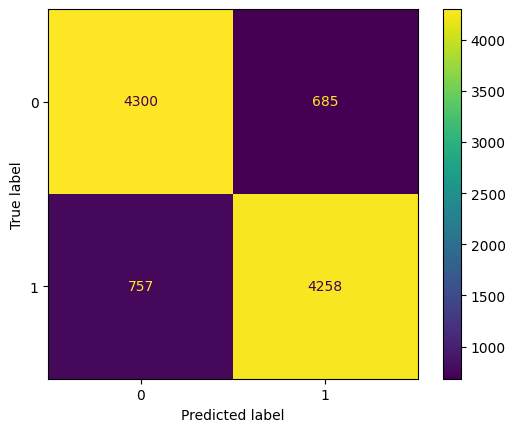

Precision: 0.86, Recall: 0.85, F1-Score: 0.86


(0.32989307294918013, tensor(0.8558, device='cuda:0'))

In [19]:
model_utils.test(test_dataloader, mod_resnet50, loss_fn, device,
                 model_name=model_name)

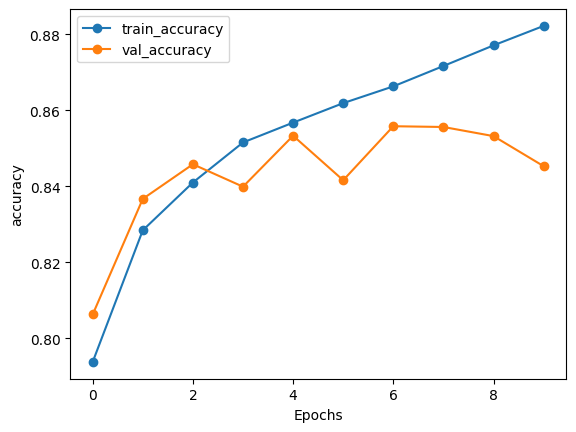

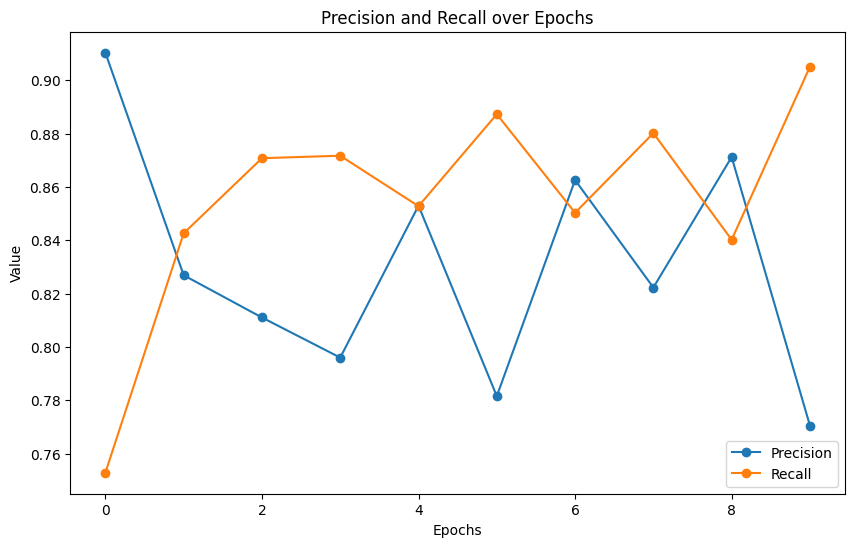

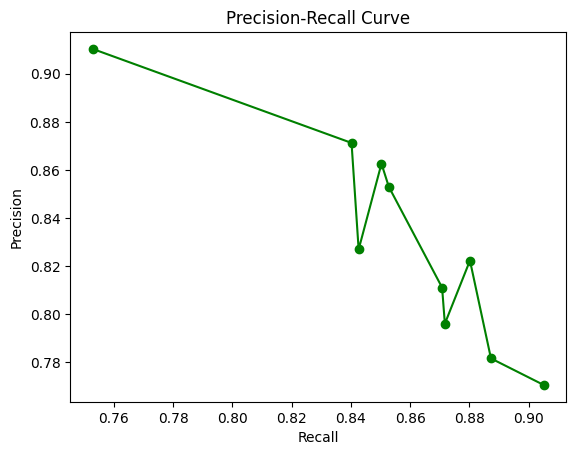

In [20]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

##### Step 2 fine-tuning on Modified ResNet

In [21]:
for param in mod_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(mod_resnet50.parameters(), lr=LEARNING_RATE)
model_name = "CIFAKE_ModResNet50_beefy"

In [22]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, mod_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/10
-------------------------------
Training loss: 0.213310, train accuracy: 87.75%  [ 5120/100000]
Training loss: 0.176563, train accuracy: 89.92%  [10240/100000]
Training loss: 0.183044, train accuracy: 91.34%  [15360/100000]
Training loss: 0.124573, train accuracy: 92.07%  [20480/100000]
Training loss: 0.070277, train accuracy: 92.74%  [25600/100000]
Training loss: 0.112998, train accuracy: 93.14%  [30720/100000]
Training loss: 0.123092, train accuracy: 93.45%  [35840/100000]
Training loss: 0.113850, train accuracy: 93.64%  [40960/100000]
Training loss: 0.107640, train accuracy: 93.82%  [46080/100000]
Training loss: 0.034325, train accuracy: 94.01%  [51200/100000]
Training loss: 0.084474, train accuracy: 94.23%  [56320/100000]
Training loss: 0.167002, train accuracy: 94.38%  [61440/100000]
Training loss: 0.097722, train accuracy: 94.48%  [66560/100000]
Training loss: 0.127153, train accuracy: 94.57%  [71680/100000]
Training loss: 0.167410, train accuracy: 94.68%  [76800/10000

Test Error:
Accuracy: 97.2%, Avg loss: 0.082961
Confusion matrix report, tp: 4859, fp: 126, fn: 157, tn:4858
True


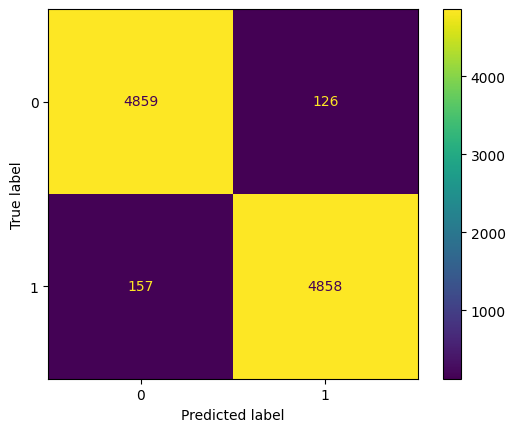

Precision: 0.97, Recall: 0.97, F1-Score: 0.97


(0.08296139477280594, tensor(0.9717, device='cuda:0'))

In [23]:
model_utils.test(test_dataloader, mod_resnet50, loss_fn, device,
                 model_name=model_name)

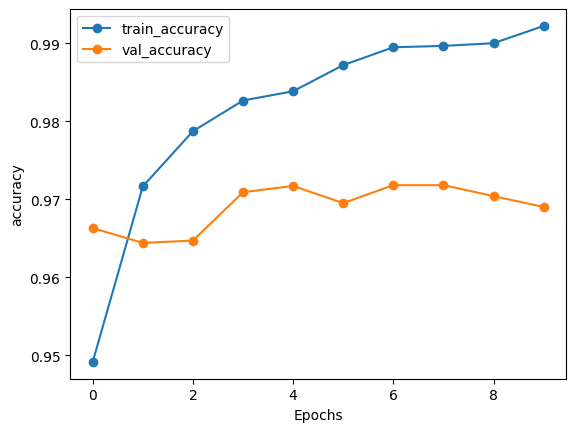

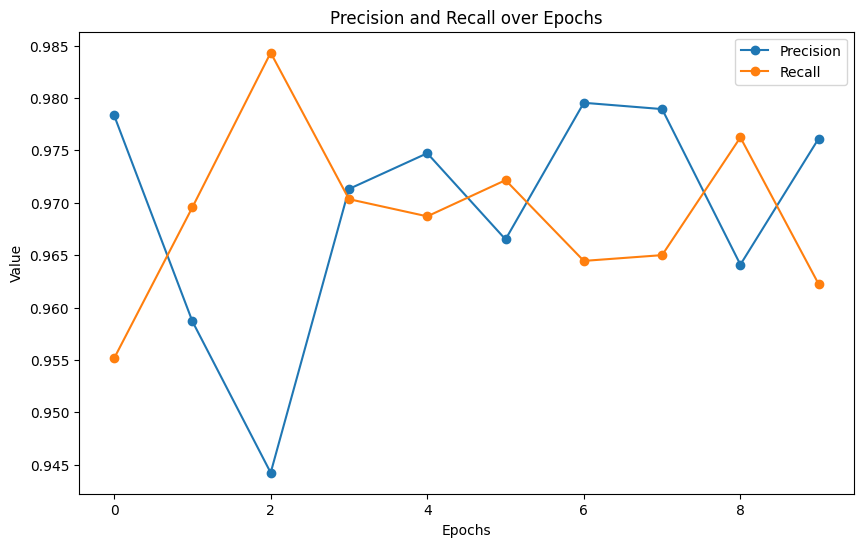

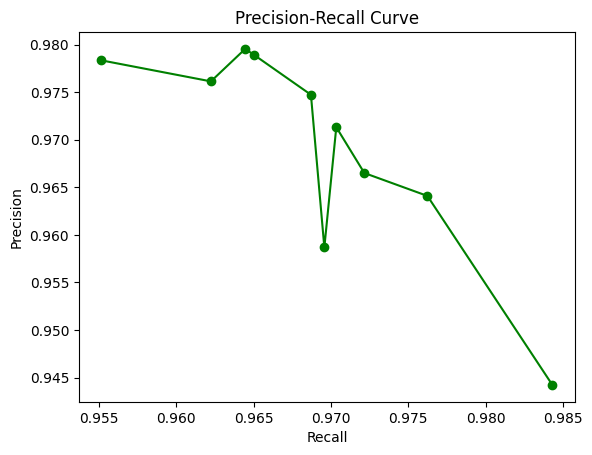

In [24]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

In [25]:
mod_resnet50 = model_utils.ModifiedResNet(original_resnet=resnet50(weights='IMAGENET1K_V1'))
mod_resnet50.to(device)
mod_resnet50.load_state_dict(torch.load("checkpoints/best_CIFAKE_ModResNet50_beefy.pth"))
model_name = "CIFAKE_ModResNet50_beefy"

C:\Users\tekke\AppData\Local\Temp\ipykernel_5328\1277077088.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mod_resnet50.load_state_dict(torch.load("checkpoints/best_CIF

### Dropout on ModResNet experiment
To improve generalization of the ModResNet model, we tried to apply a dropout layer on the three linear layers of the classification head. This, however, hindered performance even more.

In [26]:
dp_mod_resnet50 = model_utils.ModifiedResNet(original_resnet=resnet50(weights='IMAGENET1K_V1'))
dp_mod_resnet50.prepare_for_ft()
dp_mod_resnet50.to(device)

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, dp_mod_resnet50.parameters()), lr=0.001
)

model_name = "CIFAKE_ModResNet50_dropout"

In [27]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, dp_mod_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/10
-------------------------------
Training loss: 0.467195, train accuracy: 71.60%  [ 5120/100000]
Training loss: 0.510630, train accuracy: 74.71%  [10240/100000]
Training loss: 0.536703, train accuracy: 75.97%  [15360/100000]
Training loss: 0.463806, train accuracy: 76.11%  [20480/100000]
Training loss: 0.351071, train accuracy: 76.68%  [25600/100000]
Training loss: 0.415930, train accuracy: 77.10%  [30720/100000]
Training loss: 0.397589, train accuracy: 77.26%  [35840/100000]
Training loss: 0.420916, train accuracy: 77.60%  [40960/100000]
Training loss: 0.345440, train accuracy: 77.83%  [46080/100000]
Training loss: 0.413123, train accuracy: 78.05%  [51200/100000]
Training loss: 0.377161, train accuracy: 78.37%  [56320/100000]
Training loss: 0.521892, train accuracy: 78.65%  [61440/100000]
Training loss: 0.451388, train accuracy: 78.85%  [66560/100000]
Training loss: 0.386226, train accuracy: 78.93%  [71680/100000]
Training loss: 0.441401, train accuracy: 79.08%  [76800/10000

Test Error:
Accuracy: 85.3%, Avg loss: 0.338792
Confusion matrix report, tp: 4390, fp: 595, fn: 874, tn:4141
True


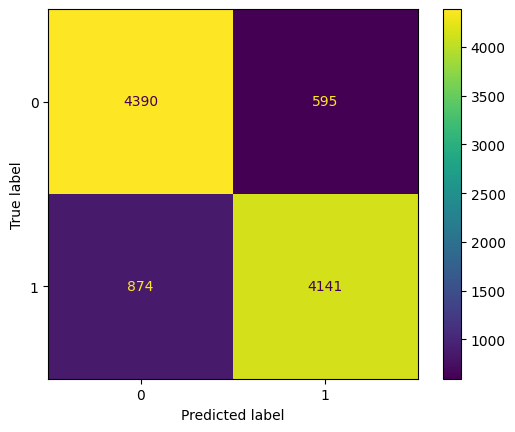

Precision: 0.88, Recall: 0.83, F1-Score: 0.86


(0.33879246647599376, tensor(0.8531, device='cuda:0'))

In [28]:
model_utils.test(test_dataloader, dp_mod_resnet50, loss_fn, device,
                 model_name=model_name)

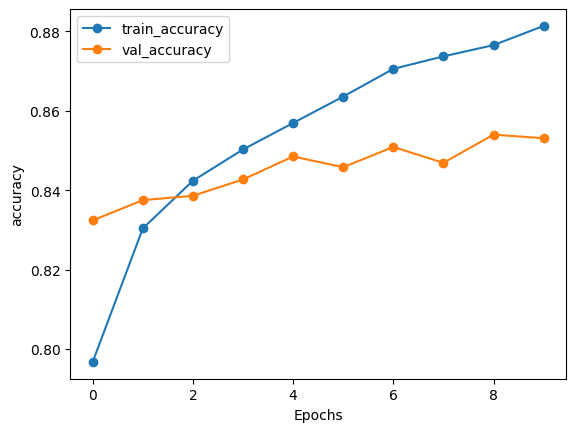

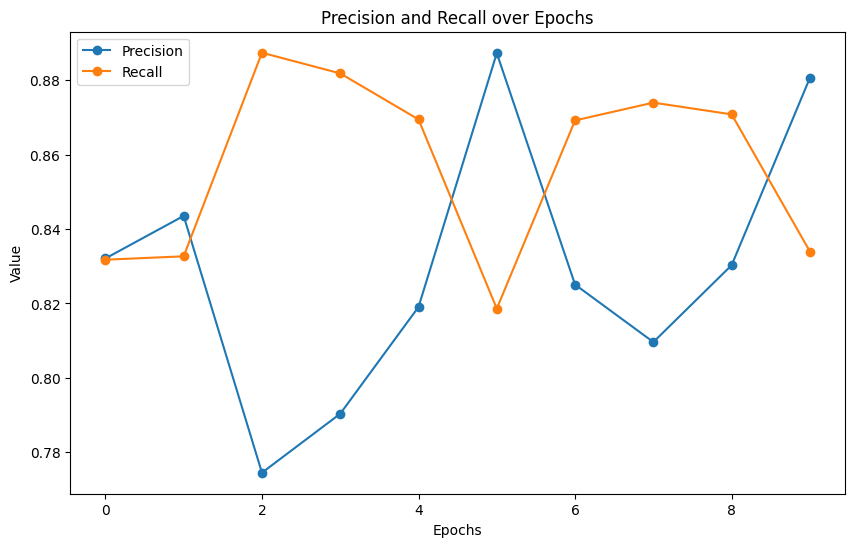

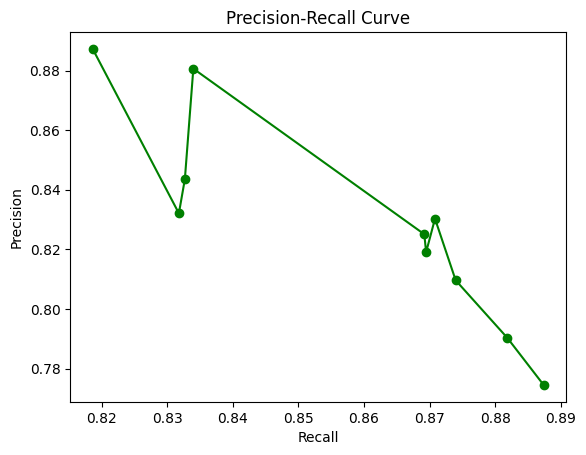

In [29]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

#### Fine-tune step 2 on DropoutExperiment

In [30]:
for param in dp_mod_resnet50.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(dp_mod_resnet50.parameters(), lr=0.001)

model_name = "CIFAKE_ModResNet50_dropout_beefy"

In [31]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, dp_mod_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/10
-------------------------------
Training loss: 0.224888, train accuracy: 83.69%  [ 5120/100000]
Training loss: 0.176181, train accuracy: 87.20%  [10240/100000]
Training loss: 0.153256, train accuracy: 88.90%  [15360/100000]
Training loss: 0.146660, train accuracy: 89.83%  [20480/100000]
Training loss: 0.151199, train accuracy: 90.70%  [25600/100000]
Training loss: 0.094246, train accuracy: 91.20%  [30720/100000]
Training loss: 0.136538, train accuracy: 91.58%  [35840/100000]
Training loss: 0.103949, train accuracy: 91.90%  [40960/100000]
Training loss: 0.150874, train accuracy: 92.17%  [46080/100000]
Training loss: 0.144150, train accuracy: 92.37%  [51200/100000]
Training loss: 0.193419, train accuracy: 92.52%  [56320/100000]
Training loss: 0.119312, train accuracy: 92.72%  [61440/100000]
Training loss: 0.104283, train accuracy: 92.89%  [66560/100000]
Training loss: 0.224862, train accuracy: 93.03%  [71680/100000]
Training loss: 0.162554, train accuracy: 93.18%  [76800/10000

Test Error:
Accuracy: 96.9%, Avg loss: 0.086962
Confusion matrix report, tp: 4822, fp: 163, fn: 149, tn:4866
True


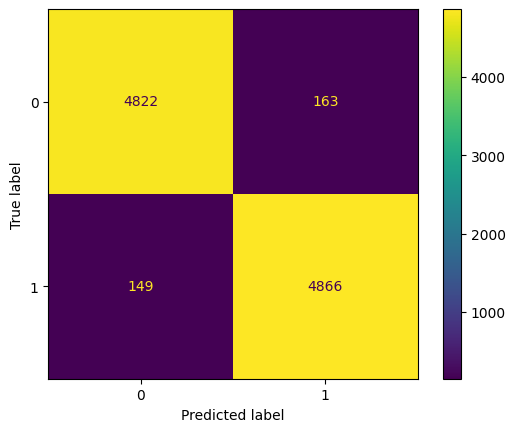

Precision: 0.97, Recall: 0.97, F1-Score: 0.97


(0.08696178577271514, tensor(0.9688, device='cuda:0'))

In [32]:
model_utils.test(test_dataloader, dp_mod_resnet50, loss_fn, device,
                 model_name=model_name)

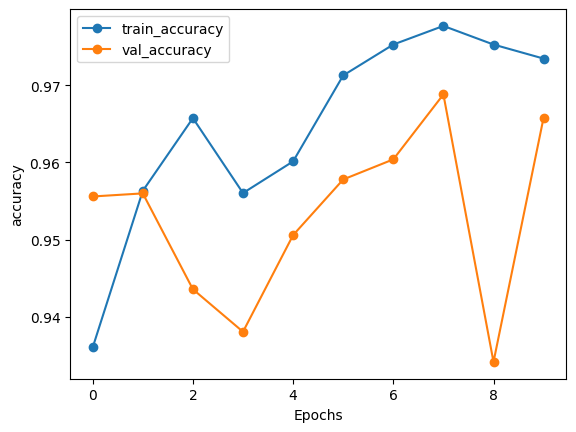

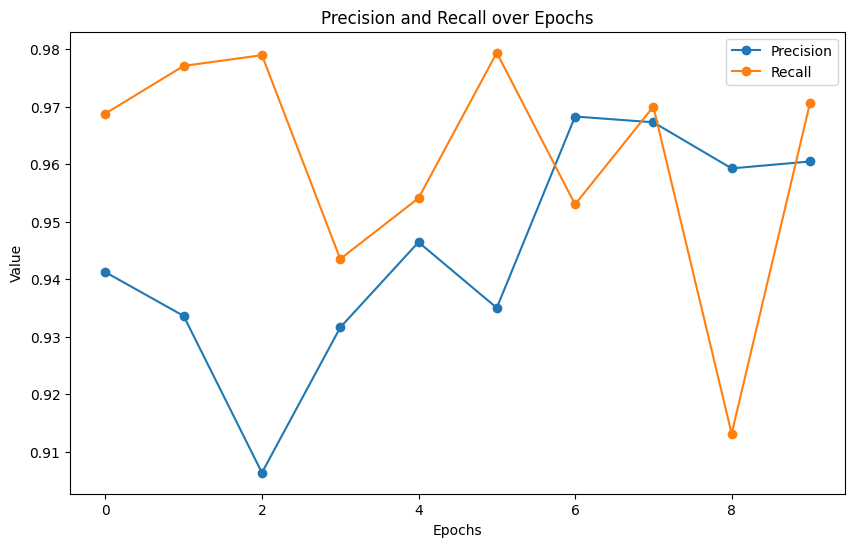

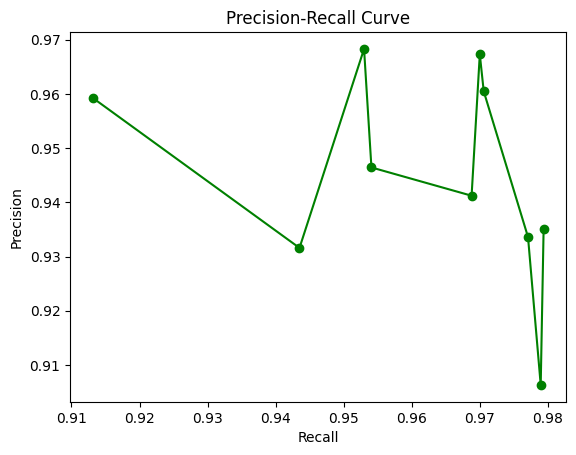

In [33]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

## xAI tests
The following cells contain some simple tests we made using xAI techniques for outcome explanation (i.e. AblationCAM, ScoreCAM and LIME).

We apply AblationCAM, ScoreCAM and LIME to the images to get an explanation on the outcomes achieved by the model.

100%|██████████| 64/64 [00:00<00:00, 103.47it/s]


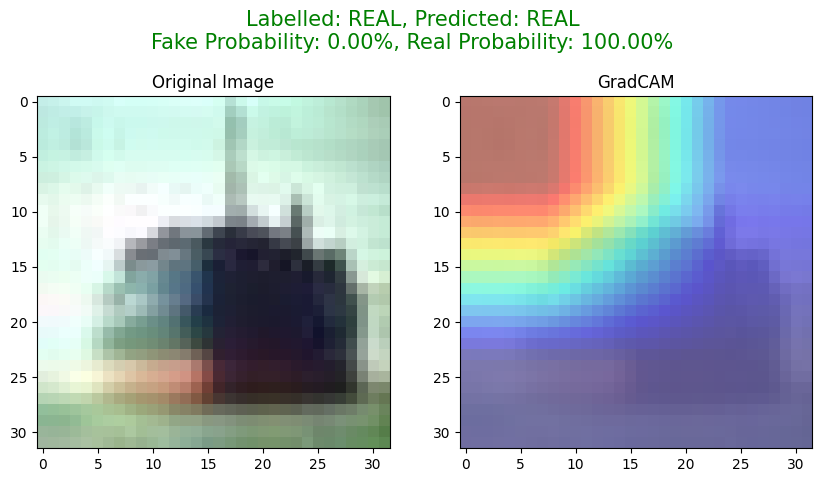

In [ ]:
target_layers =  [ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4]

xai.explain_gradcam_single_image(test_dataloader, ft_resnet50, target_layers,
                                 model_name=model_name, dataset_name=DATASET_NAME,
                                 index = 15)

  0%|          | 0/1000 [00:00<?, ?it/s]

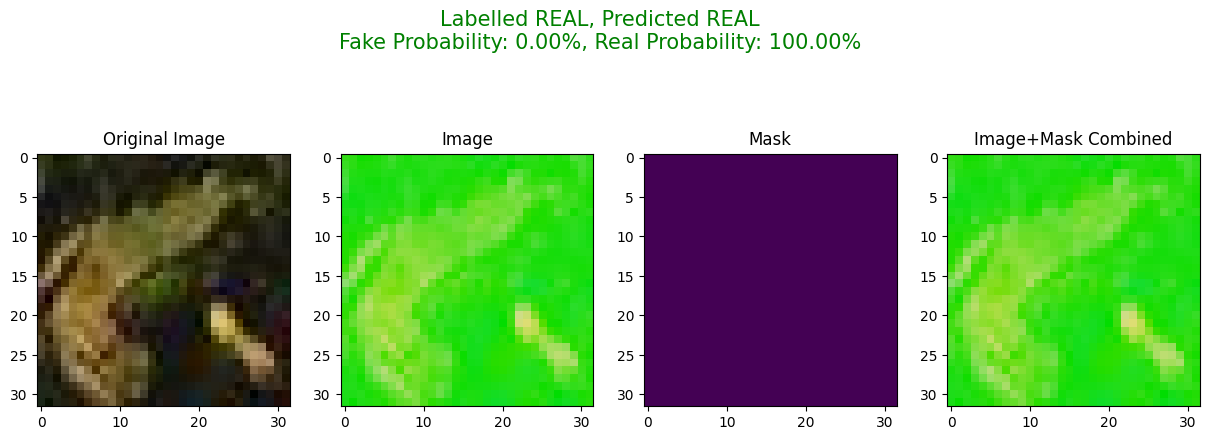

In [ ]:
xai.explain_lime_single_image(test_dataloader, ft_resnet50,
                                model_name=model_name, dataset_name=DATASET_NAME,
                                index = 5)

The xAI frameworks perform poorly on CIFAKE images, as the are very low resolution (32x32). In future experiment (in MIXED model for example), we'll see that we can gain better explanation on CIFAKE samples by upscaling the images to 224x224.

### xAI batch visualizations
This code allows us to save some samples of a batch of AblationCAM and LIME, and it's only for data analysis purposes.

In [ ]:
model_name = "CIFAKE_FTResNet50"
xai.explain_gradcam_batch(test_dataloader, test_dataloader.batch_size,
                          mod_resnet50, target_layers, model_name, DATASET_NAME)

In [ ]:
xai.explain_lime_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50,
                                model_name=model_name, dataset_name=DATASET_NAME,
                                )

## Experiment: testing CIFAKE_ResNet50 on RVAA dataset
We're going to test the CIFAKE model on the RealVsAiArt dataset, which is far different in specification compared to CIFAKE.

The dataset contains AI generated images from various models, or images which only part of it is AI generated.

In [8]:
# import model to finetune
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=2)
ft_resnet50.to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)
model_name = "CIFAKE_FTResNet50"

IMG_SIZE = 224

transform_cifake = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')), # Convert to RGB
    transforms.Resize((IMG_SIZE, IMG_SIZE)),                # upscale to IMG_SIZE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])        # normalize pixel values
])

LEARNING_RATE = 3e-4
EPOCHS = 10
BATCH_SIZE = 128
DATASET_NAME = "CIFAKE"

In [9]:
transform_rvaa = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')), # Convert to RGB
    transforms.Resize(IMG_SIZE),                 # Resize to IMG_SIZE while keeping aspect ratio
    transforms.Lambda(data_utils.pad_to_square), # Apply the dynamic padding to make the image square
    transforms.Resize((IMG_SIZE, IMG_SIZE)),     # Ensure the final image is IMG_SIZExIMG_SIZE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing "should" help with Pretrained nets
])

In [10]:
rvaa_dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform_rvaa)
rvaa_dataloader = DataLoader(rvaa_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)

train_data = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="train", transform=transform_cifake)
test_data = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="test", transform=transform_cifake)

val_data, test_data = data_utils.train_test_split(0.5, dataset=test_data, isRandom=True)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, pin_memory=True)
dataloaders = (train_dataloader, test_dataloader)

Since we'll be using 224x224 upscaled images, we need to retrain the model using the same two-step fine-tune technique as before.

In [11]:
model_name = "CIFAKE_FTResNet50_UPSCALED"

artifacts = model_utils.train(dataloaders, loss_fn, optimizer,
                              ft_resnet50, model_name, BATCH_SIZE,
                              EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/10
-------------------------------
Training loss: 0.566486, train accuracy: 73.52%  [ 5120/100000]
Training loss: 0.500731, train accuracy: 77.89%  [10240/100000]
Training loss: 0.408326, train accuracy: 79.61%  [15360/100000]
Training loss: 0.367672, train accuracy: 80.59%  [20480/100000]
Training loss: 0.425643, train accuracy: 81.30%  [25600/100000]
Training loss: 0.365941, train accuracy: 81.71%  [30720/100000]
Training loss: 0.409277, train accuracy: 82.20%  [35840/100000]
Training loss: 0.323863, train accuracy: 82.64%  [40960/100000]
Training loss: 0.333764, train accuracy: 82.94%  [46080/100000]
Training loss: 0.350398, train accuracy: 83.31%  [51200/100000]
Training loss: 0.317375, train accuracy: 83.60%  [56320/100000]
Training loss: 0.350376, train accuracy: 83.88%  [61440/100000]
Training loss: 0.313866, train accuracy: 84.02%  [66560/100000]
Training loss: 0.392976, train accuracy: 84.15%  [71680/100000]
Training loss: 0.278279, train accuracy: 84.31%  [76800/10000

In [12]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)
model_name = "CIFAKE_FTResNet50_UPSCALED_beefy"

In [13]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/10
-------------------------------
Training loss: 0.217846, train accuracy: 89.34%  [ 5120/100000]
Training loss: 0.092145, train accuracy: 91.88%  [10240/100000]
Training loss: 0.118729, train accuracy: 92.83%  [15360/100000]
Training loss: 0.171237, train accuracy: 93.35%  [20480/100000]
Training loss: 0.091087, train accuracy: 93.77%  [25600/100000]
Training loss: 0.081900, train accuracy: 93.97%  [30720/100000]
Training loss: 0.129112, train accuracy: 94.19%  [35840/100000]
Training loss: 0.180555, train accuracy: 94.38%  [40960/100000]
Training loss: 0.084035, train accuracy: 94.56%  [46080/100000]
Training loss: 0.047820, train accuracy: 94.68%  [51200/100000]
Training loss: 0.076777, train accuracy: 94.78%  [56320/100000]
Training loss: 0.165113, train accuracy: 94.90%  [61440/100000]
Training loss: 0.043779, train accuracy: 95.01%  [66560/100000]
Training loss: 0.242727, train accuracy: 95.09%  [71680/100000]
Training loss: 0.149594, train accuracy: 95.15%  [76800/10000

Test Error:
Accuracy: 97.8%, Avg loss: 0.065807
Confusion matrix report, tp: 4926, fp: 97, fn: 123, tn:4854
True


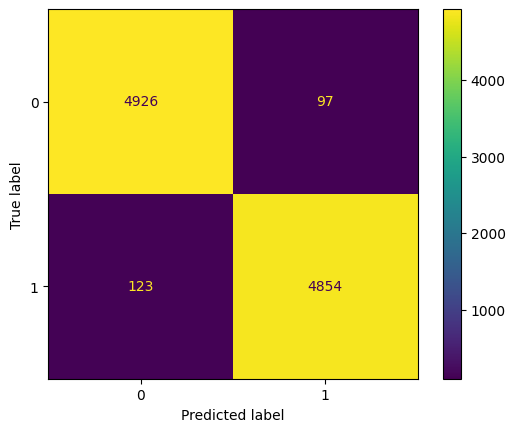

Precision: 0.98, Recall: 0.98, F1-Score: 0.98


(0.0658066664008966, tensor(0.9780, device='cuda:0'))

In [14]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)

Now, we're going to run the newly trained CIFAKE model on the whole RVAA dataset.

c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Error:
Accuracy: 55.4%, Avg loss: 19.489548
Confusion matrix report, tp: 8, fp: 426, fn: 7, tn:529
True


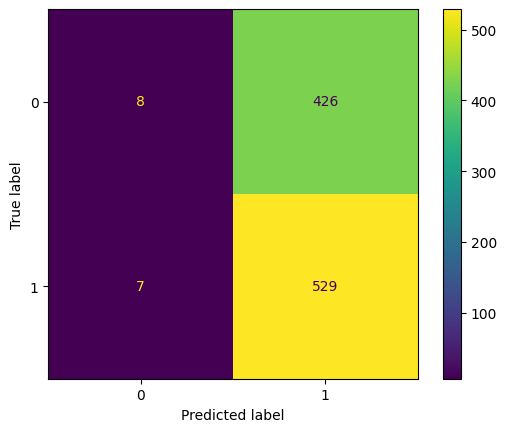

Precision: 0.02, Recall: 0.53, F1-Score: 0.04


(19.489548444747925, tensor(0.5536, device='cuda:0'))

In [15]:
model_utils.test(rvaa_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)